In [5]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython import display
import pickle
import ast
import math 
import traceback
from sklearn import preprocessing
from ucimlrepo import fetch_ucirepo 

import seaborn as sns

In [2]:
%matplotlib inline
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
import os, ssl
if (not os.environ.get('PYTHONHTTPSVERIFY', '') and
    getattr(ssl, '_create_unverified_context', None)): 
    ssl._create_default_https_context = ssl._create_unverified_context

In [4]:
dataset_name = "splice"

In [1]:
import seaborn as sns

In [2]:
import matplotlib
matplotlib.__version__

'3.7.1'

In [175]:
# fetch dataset 
credit_approval = fetch_ucirepo(id=69) 
  
# data (as pandas dataframes) 
X = credit_approval.data.features 
y = credit_approval.data.targets 
  
# metadata 
print(credit_approval.metadata) 
  
# variable information 
print(credit_approval.variables) 

{'uci_id': 69, 'name': 'Molecular Biology (Splice-junction Gene Sequences)', 'repository_url': 'https://archive.ics.uci.edu/dataset/69/molecular+biology+splice+junction+gene+sequences', 'data_url': 'https://archive.ics.uci.edu/static/public/69/data.csv', 'abstract': 'Primate splice-junction gene sequences (DNA) with associated imperfect domain theory', 'area': 'Biology', 'tasks': ['Classification'], 'characteristics': ['Sequential', 'Domain-Theory'], 'num_instances': 3190, 'num_features': 60, 'feature_types': ['Categorical'], 'demographics': [], 'target_col': ['class'], 'index_col': ['instancename'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1991, 'last_updated': 'Mon Mar 04 2024', 'dataset_doi': '10.24432/C5M888', 'creators': [], 'intro_paper': None, 'additional_info': {'summary': 'Problem Description: \r\n      \r\nSplice junctions are points on a DNA sequence at which `superfluous\' DNA is removed during the process of protein creation in

In [176]:
is_receptor_or_donor = (y["class"] != "N").values
y = y[is_receptor_or_donor]
X = X.iloc[is_receptor_or_donor]

In [177]:
categorical_cols = X.columns
# One-hot encode the categorical columns
df_encoded = pd.get_dummies(X, columns=categorical_cols)
# Initialize a scaler
scaler = preprocessing.StandardScaler()
# Fit and transform the data
X = pd.DataFrame(scaler.fit_transform(df_encoded), columns=df_encoded.columns)
X = X.fillna(0)

# to numpy
X = X.values

In [178]:
set(y["class"])

{'EI', 'IE'}

In [179]:
X.shape

(1535, 284)

In [180]:
y.shape

(1535, 1)

In [181]:
y

,class
0,EI
1,EI
2,EI
3,EI
4,EI
...,...
1530,IE
1531,IE
1532,IE
1533,IE


In [182]:
y = np.array([0.0 if elem == "IE" else 1.0 for elem in y["class"]])

In [183]:
from sklearn import model_selection

In [184]:
X, Xtest, y, ytest = model_selection.train_test_split(X, y)

In [185]:
y.mean()

0.5056472632493484

In [186]:
ytest.sum()

185.0

## Specify learning algorithms

In [187]:
import math


def sigmoid(x):
    x = np.clip(x, -200, 200)
    y = 1 / (1 + np.exp(-x))
    return y


def forward_logloss(X, theta):
    y = np.dot(X, theta.T)
    #print(f"{X=}")
    #print(f"{theta.T=}")
    #print(f"{y=}")
    y = sigmoid(y)
    #print(f"{y=}")
    return y


def backward_logloss(xx, yy, p):
    grad = (p - yy) * xx
    return grad


def cross_entropy(p, y, epsilon=1e-45):
    l = -np.mean(
        y * np.log(np.maximum(p, epsilon))
        + (1 - y) * np.log(np.maximum(1 - p, epsilon))
    )
    #print(f"{p=}")
    #print(f"{y=}")
    #print(f"{l=}")
    return l


def accuracy_prob(p, y):
    y = y.flatten()
    p = p.flatten()
    sy = 2 * y - 1
    sp = np.sign(p - 1 / 2)
    a = (np.sign(sy * sp) + 1) / 2
    return np.mean(a)


def ratio(u):
    if u <= 10:
        y = ((1 + math.exp(u)) ** 2) * math.log(1 + math.exp(-u))
    else:
        y = math.exp(u)
    return y


def log_ratio(u):
    if u <= 10:
        y = ((1 + np.exp(u)) ** 2) * np.log1p(np.exp(-u))
        log_y = np.log(y)
    else:
        log_y = u
    return log_y


def update(theta, grad, eta=0.01, lam=2):
    newtheta = theta - eta * (grad + 0.5 * lam * theta)
    return newtheta

In [188]:
loss = cross_entropy
forward = forward_logloss
backward = backward_logloss
accuracy = accuracy_prob

def train_model(
    X,
    y,
    Xtest,
    ytest,
    mode="rand",
    eta=0.01,
    lam=1,
    # Used in all the Polyak methods
    kappa=1,
    kappa0=0.1,
    # Used in Polyak and Polyak-bec
    polyakexp=1 / 2,
    # Used in polyak-becpi
    omega=1,
    # Added to enable non-adaptive stepsize experiments with pz != 1/2
    pz0 = 1/2,
    # For bec-minx1
    alpha = 1,
    x0 = 1,
    # multiplier to control sampling probability in bec-absloss
    prob_const = 1,
    # debug
    verbose=True,
    epsilon = 1e-45,
    max_iterations = 6600
):
    theta = np.zeros(X.shape[1])
    stheta = theta

    n_iterations = min(X.shape[0], max_iterations)  # Number of iterations
    #thetas = np.zeros((n_iterations, X.shape[1]))
    
    if verbose:
        print(f"Training with algorithm {mode}: {n_iterations} iterations with d={X.shape[1]}")
        
    losses = np.zeros(n_iterations)
    losses_reg = np.zeros(n_iterations)
    losses_test = np.zeros(n_iterations)
    losses_test_reg = np.zeros(n_iterations)
    accuracies = np.zeros(n_iterations)
    accuracies_test = np.zeros(n_iterations)
    labeled = np.zeros(n_iterations)
    #Delta = np.zeros(n_iterations)
    #sDelta = np.zeros(n_iterations)
    probs = np.zeros(n_iterations)
    #samples = []

    # for i in range(npoints):
    for i in range(n_iterations):
        xx = X[i, :]
        yy = y[i]

        p = 0
        q = 0
        pz = 1 / 2
        grad = 0

        if mode == "random":
            pz = pz0
            p = forward(xx, theta)
            grad = backward(xx, yy, p)
        elif mode == "polyak_absloss":
            p = forward(xx, theta)
            grad = backward(xx, yy, p)
            u = (2 * yy - 1) * np.dot(xx, theta)
            zeta = kappa * ratio(u) / (np.linalg.norm(xx) ** 2)
            zeta = min(zeta, kappa0)
            pz = omega / (1 + np.exp(u))
            pz = np.clip(pz, a_min=0, a_max=1)
            grad = zeta * grad / pz
        elif mode == "polyak_exponent": 
            p = forward(xx, theta)
            grad = backward(xx, yy, p)
            u = (2 * yy - 1) * np.dot(xx, theta)
            #zeta = kappa * (ratio(u) / (np.linalg.norm(xx) ** 2))
            zeta_log = math.log(kappa) + log_ratio(u) - math.log(np.linalg.norm(xx) ** 2)
            #zeta = math.exp(zeta_log)
            #zeta = min(zeta, kappa0)
            zeta = math.exp(min(zeta_log, math.log(kappa0)))
            pz = zeta ** polyakexp
            pz = np.clip(pz, a_min=epsilon, a_max=1-epsilon)
            grad = (zeta ** (1 - polyakexp)) * grad
        elif mode == "polyak_exponent_old": 
            p = forward(xx, theta)
            grad = backward(xx, yy, p)
            u = (2 * yy - 1) * np.dot(xx, theta)
            zeta = kappa * ratio(u) / (np.linalg.norm(xx) ** 2)
            zeta = min(zeta, kappa0)
            pz = zeta ** polyakexp
            grad = (zeta ** (1 - polyakexp)) * grad
        elif mode == "absloss":
            p = forward(xx, theta)
            bec = cross_entropy(p, yy)
            pz = 1 - np.exp(-bec)
            pz = omega * pz
            pz = np.clip(pz, a_min=epsilon, a_max=1-epsilon)
            grad = backward(xx, yy, p)
        elif mode == "minx1":  
            p = forward(xx, theta)
            bec = cross_entropy(p, yy)
            pz = np.min([(bec / x0) ** alpha, 1])
            grad = backward(xx, yy, p)
        elif mode == "polyak-minx1":
            # Binary cross-entropy loss with Polyak adaptive step size
            p = forward(xx, theta)
            bec = cross_entropy(p, yy)
            grad = backward(xx, yy, p)
            
            # Compute pz as in bec-minx1 mode
            pz = np.min([(bec / x0) ** alpha, 1])

            # Compute u and zeta as in polyak-bec mode
            u = (2 * yy - 1) * np.dot(xx, theta)
            zeta = kappa * ratio(u) / (np.linalg.norm(xx) ** 2)
            zeta = min(zeta, kappa0)
            
            # Compute the gradient of the binary cross-entropy loss with respect to theta
            dL_dpz = -(y / pz - (1 - y) / (1 - pz))
            dL_dbec = 0 if (bec / x0) > 1 else alpha * ((bec / x0) ** (alpha - 1)) / x0

            # Apply the Polyak adaptive step size to the gradient
            scaling_factor = zeta ** (1 - polyakexp)
            grad = scaling_factor * grad

        # sampling
        pz = np.clip(pz, epsilon, 1-epsilon)
        z = np.random.binomial(1, pz)
        #print(f"{p=}")
        #print(f"{yy=}")
        losses[i] = loss(p, yy)
        losses_reg[i] = losses[i] + lam * np.linalg.norm(theta)
        
        #stheta = (1 - 1 / (i + 1)) * stheta + (1 / (i + 1)) * theta
        accuracies[i] = accuracy(p, yy)

        labeled[i] = z
        probs[i] = pz
        # parameter update
        if z > 0:
            theta = update(theta, grad, eta=eta, lam=lam)
            #samples.append(i)

        """
        theta_norm = theta
        if np.linalg.norm(theta)>0:
          theta_norm = theta / np.linalg.norm(theta)
        Delta.append(np.linalg.norm(theta_norm-theta_star))

        stheta_norm = stheta
        if np.linalg.norm(stheta)>0:
          stheta_norm = stheta / np.linalg.norm(stheta)
        sDelta.append(np.linalg.norm(stheta_norm-theta_star))
        """

        p = forward(Xtest, theta)
        #print(f"{p=}")
        #print(f"{ytest=}")
        losses_test[i] = loss(p, ytest)
        losses_test_reg[i] = losses_test[i] + lam * np.linalg.norm(theta)
        accuracies_test[i] = accuracy(p, ytest)
        
        """
        p = forward(Xtest, stheta)
        ltest = loss(p, ytest) + lam * np.linalg.norm(stheta)
        slosses_test.append(ltest)
        """
        
        #p = forward(Xtest, theta)

        """
        p = forward(Xtest, stheta)
        a = accuracy(p, ytest)
        saccuracies_test.append(a)
        """

        if verbose and i % 10 == 0:
            print(f"loss: {losses_test[i]}, train loss: {losses[i]}, ||theta||_1: {np.sum(np.abs(theta))} acc: {accuracies[i]}")

    return {
        "losses": losses.tolist(),
        "losses_reg": losses_reg.tolist(),
        "losses_test": losses_test.tolist(),
        "losses_test_reg": losses_test_reg.tolist(),
        "labeled": labeled.tolist(),
        "theta": theta.tolist(),
        #"stheta": stheta,
        "probs": probs.tolist(),
        "accuracies": accuracies.tolist(),
        "accuracies_test": accuracies_test.tolist(),
        #"samples": samples.tolist(),
        #"thetas": thetas.tolist(),
    }

## Use best hyperparams to construct plot
We have stored results from our hyperparameter tuning run. Here we load the results file, and will use the best hyperparameters per method.

In [189]:
hyperparam_results = pd.read_csv("hyperparams_train_loss_zero_init_noreg_target050_eta300.csv", delimiter="\t", header=None)
hyperparam_results.columns = ["algorithm", "loss", "hyperparams"]

In [190]:
# Calculate best hyperparameters per method
min_losses = pd.DataFrame(hyperparam_results.groupby("algorithm").loss.min()).reset_index()
best_hyperparams = min_losses.merge(hyperparam_results, on=["algorithm", "loss"], how="left")

hyperparam_per_algo = {
    algorithm: ast.literal_eval(hyperparam) for 
    algorithm, hyperparam in 
    zip(best_hyperparams["algorithm"], best_hyperparams["hyperparams"])
}

In [233]:
hyperparam_per_algo["absloss"] = {"eta": 0.1}
hyperparam_per_algo["random"] = {"eta": 0.1}
hyperparam_per_algo["polyak_absloss"] |= {
    "eta": 0.1,
    "kappa": 10,
    "kappa0": 0.9,
    "omega": 1.0
}
hyperparam_per_algo["polyak_exponent"] |= {
    "eta": 0.1,
    "kappa": 10,
    "kappa0": 0.9,
    "omega": 1.10
}

In [234]:
hyperparam_per_algo

{'polyak_absloss': {'kappa': 10, 'kappa0': 0.9, 'eta': 0.1, 'omega': 1.0},
 'polyak_exponent': {'kappa': 10,
  'kappa0': 0.9,
  'eta': 0.1,
  'polyakexp': 0.9951814804061615,
  'omega': 1.1},
 'absloss': {'eta': 0.1},
 'random': {'eta': 0.1}}

# Plot 0: train loss of rand vs absloss (first run for absloss, then run for rand for matching pz)

- mean train loss curve
- mean test loss curve
- accuracy

In [235]:
X

array([[-0.51623798,  1.58511382, -0.02553215, ..., -0.73458754,
        -0.02553215,  1.87122053],
       [-0.51623798, -0.63086952, -0.02553215, ..., -0.73458754,
        -0.02553215, -0.53441055],
       [ 1.93709111, -0.63086952, -0.02553215, ..., -0.73458754,
        -0.02553215, -0.53441055],
       ...,
       [ 1.93709111, -0.63086952, -0.02553215, ..., -0.73458754,
        -0.02553215,  1.87122053],
       [-0.51623798,  1.58511382, -0.02553215, ..., -0.73458754,
        -0.02553215,  1.87122053],
       [ 1.93709111, -0.63086952, -0.02553215, ...,  1.36130814,
        -0.02553215, -0.53441055]])

In [236]:
absloss_params = hyperparam_per_algo["absloss"]

results_absloss = train_model(
    X, y, Xtest, ytest, mode="absloss", **absloss_params
)

Training with algorithm absloss: 1151 iterations with d=284
loss: 0.6931471805599453, train loss: 0.6931471805599453, ||theta||_1: 0.0 acc: 0.5
loss: 0.6200454282275571, train loss: 0.27713323147741864, ||theta||_1: 14.239285829563121 acc: 1.0
loss: 0.43286777548324484, train loss: 0.0891342146951569, ||theta||_1: 23.197325976712676 acc: 1.0
loss: 0.5022856696585131, train loss: 0.3647277608556794, ||theta||_1: 34.79047638851576 acc: 1.0
loss: 0.5022856696585131, train loss: 0.014470163311049042, ||theta||_1: 34.79047638851576 acc: 1.0
loss: 0.38222800558883635, train loss: 0.006815151845104315, ||theta||_1: 36.67232569118302 acc: 1.0
loss: 0.32029331724256377, train loss: 0.0005715869389971374, ||theta||_1: 37.93152462852798 acc: 1.0
loss: 0.32029331724256377, train loss: 0.10276139297788643, ||theta||_1: 37.93152462852798 acc: 1.0
loss: 0.3134178110544435, train loss: 0.0005121490403874775, ||theta||_1: 38.069240315163455 acc: 1.0
loss: 0.3900273958042875, train loss: 0.0084495183984

loss: 0.31898135540464806, train loss: 0.26437213302822093, ||theta||_1: 44.69844404231415 acc: 1.0
loss: 0.321421757439358, train loss: 0.15743200380262382, ||theta||_1: 44.398381254362945 acc: 1.0
loss: 0.321421757439358, train loss: 0.07075820102188153, ||theta||_1: 44.398381254362945 acc: 1.0
loss: 0.30219635963408714, train loss: 3.912928222277924e-06, ||theta||_1: 45.81647571762235 acc: 1.0
loss: 0.2675549578545809, train loss: 0.0007997359489307942, ||theta||_1: 45.072907443333534 acc: 1.0
loss: 0.24492180712705877, train loss: 0.04520602238253443, ||theta||_1: 43.15136036277066 acc: 1.0
loss: 0.26322596937133913, train loss: 0.10450665393562987, ||theta||_1: 40.375659165885295 acc: 1.0
loss: 0.2104479658361702, train loss: 0.8270201269314892, ||theta||_1: 38.611661431126926 acc: 0.0
loss: 0.2882930833663318, train loss: 1.9487707344820278, ||theta||_1: 40.6859498043904 acc: 0.0
loss: 0.2882930833663318, train loss: 0.0007620126123364273, ||theta||_1: 40.6859498043904 acc: 1.0
l

In [237]:
absloss_mean_sampling_prob = np.mean(results_absloss["probs"])

In [238]:
absloss_mean_sampling_prob

0.16082697053506928

In [239]:
rand_params = hyperparam_per_algo["random"]

results_rand = train_model(
    X, y, Xtest, ytest, mode="random", verbose=True, **(rand_params | {"pz0": absloss_mean_sampling_prob})
)

Training with algorithm random: 1151 iterations with d=284
loss: 0.6931471805599453, train loss: 0.6931471805599453, ||theta||_1: 0.0 acc: 0.5
loss: 0.5351706455087731, train loss: 0.3376627999588654, ||theta||_1: 10.265589295727366 acc: 1.0
loss: 0.4733792334506961, train loss: 0.4155670736582507, ||theta||_1: 17.7549105620056 acc: 1.0
loss: 0.48448797364562407, train loss: 0.07460498618130229, ||theta||_1: 18.951523343368315 acc: 1.0
loss: 0.44897356404525723, train loss: 0.18940663473736605, ||theta||_1: 17.89673541821471 acc: 1.0
loss: 0.416844422286298, train loss: 2.8238069923045295, ||theta||_1: 17.88543216582633 acc: 0.0
loss: 0.416844422286298, train loss: 0.007044299479238536, ||theta||_1: 17.88543216582633 acc: 1.0
loss: 0.416844422286298, train loss: 0.035805677676512306, ||theta||_1: 17.88543216582633 acc: 1.0
loss: 0.40493737904007293, train loss: 0.021087509820661255, ||theta||_1: 17.233105313711107 acc: 1.0
loss: 0.37017828507849165, train loss: 0.5083367276665729, ||th

loss: 0.24655218973488316, train loss: 0.033868513503067466, ||theta||_1: 18.315569731746788 acc: 1.0
loss: 0.32972718093720255, train loss: 1.2994489049621194, ||theta||_1: 20.814056239913565 acc: 0.0
loss: 0.3282946260461362, train loss: 0.2983408174179519, ||theta||_1: 18.969046544752665 acc: 1.0
loss: 0.30874636358977564, train loss: 0.32451924562570517, ||theta||_1: 17.608336794481104 acc: 1.0
loss: 0.283688644387809, train loss: 0.18446521508197306, ||theta||_1: 16.92162968253063 acc: 1.0
loss: 0.30245560512216074, train loss: 0.15323945092281802, ||theta||_1: 16.05044418045795 acc: 1.0
loss: 0.2503110904034537, train loss: 0.21984457847911537, ||theta||_1: 17.924821145409343 acc: 1.0
loss: 0.24426847546409572, train loss: 0.03258386777767683, ||theta||_1: 17.243793592505614 acc: 1.0
loss: 0.31310796122834056, train loss: 0.019492097573725, ||theta||_1: 18.543688053127923 acc: 1.0
loss: 0.31310796122834056, train loss: 0.359243053087984, ||theta||_1: 18.543688053127923 acc: 1.0


In [240]:
results_rand_absloss_params = train_model(
    X, y, Xtest, ytest, mode="random", verbose=True, **(absloss_params | {"pz0": absloss_mean_sampling_prob})
)

Training with algorithm random: 1151 iterations with d=284
loss: 0.6931471805599453, train loss: 0.6931471805599453, ||theta||_1: 0.0 acc: 0.5
loss: 0.5553949263377412, train loss: 0.6131932276573862, ||theta||_1: 14.529077863823403 acc: 1.0
loss: 0.47559412195712397, train loss: 0.1994735338531379, ||theta||_1: 20.657138348416254 acc: 1.0
loss: 0.38060431512277026, train loss: 0.6947054612399576, ||theta||_1: 21.029781292593263 acc: 0.0
loss: 0.36359457467729844, train loss: 0.043156411255012336, ||theta||_1: 19.919942571394046 acc: 1.0
loss: 0.3558687129439313, train loss: 0.051414397158277524, ||theta||_1: 18.96481521846499 acc: 1.0
loss: 0.31442383554068476, train loss: 0.032167711352099865, ||theta||_1: 18.448193761989046 acc: 1.0
loss: 0.3011246008126666, train loss: 0.0416109627029533, ||theta||_1: 16.463867931648767 acc: 1.0
loss: 0.28814732514996205, train loss: 0.010866634880050114, ||theta||_1: 16.01153942398333 acc: 1.0
loss: 0.28891464523543825, train loss: 0.1208093853688

loss: 0.3068759570483483, train loss: 0.4786221304969291, ||theta||_1: 18.523118758145543 acc: 1.0
loss: 0.3068759570483483, train loss: 0.0030105903973134483, ||theta||_1: 18.523118758145543 acc: 1.0
loss: 0.3068759570483483, train loss: 0.027133626342642173, ||theta||_1: 18.523118758145543 acc: 1.0
loss: 0.29297115148680924, train loss: 0.048669234201552176, ||theta||_1: 16.64298624776451 acc: 1.0
loss: 0.29977015752369235, train loss: 0.07110101597184373, ||theta||_1: 15.33874911285203 acc: 1.0
loss: 0.348600080413727, train loss: 0.01911090565630418, ||theta||_1: 15.352553123927446 acc: 1.0
loss: 0.31694601154562885, train loss: 0.3068860719360587, ||theta||_1: 16.480422254190884 acc: 1.0
loss: 0.3319007003830305, train loss: 0.045031080973327905, ||theta||_1: 18.50503937564934 acc: 1.0
loss: 0.3319007003830305, train loss: 0.06087694696845513, ||theta||_1: 18.50503937564934 acc: 1.0
loss: 0.32860949856623684, train loss: 0.06433550647471971, ||theta||_1: 17.85843480915244 acc: 1.0

In [241]:
results_absloss_rand_params = train_model(
    X, y, Xtest, ytest, mode="absloss", verbose=True, **rand_params
)

Training with algorithm absloss: 1151 iterations with d=284
loss: 0.6931471805599453, train loss: 0.6931471805599453, ||theta||_1: 0.0 acc: 0.5
loss: 0.3893240336176404, train loss: 0.6171028624403783, ||theta||_1: 20.77636938532393 acc: 1.0
loss: 0.41294714051395937, train loss: 0.5226770432636934, ||theta||_1: 23.067662092376025 acc: 1.0
loss: 0.41294714051395937, train loss: 0.0754864151002697, ||theta||_1: 23.067662092376025 acc: 1.0
loss: 0.41294714051395937, train loss: 0.007191981609984627, ||theta||_1: 23.067662092376025 acc: 1.0
loss: 0.41294714051395937, train loss: 0.07956998959721254, ||theta||_1: 23.067662092376025 acc: 1.0
loss: 0.4044875100512512, train loss: 0.006993281857409002, ||theta||_1: 22.019687483208514 acc: 1.0
loss: 0.42615422651993123, train loss: 0.04370387827739681, ||theta||_1: 26.327044627444316 acc: 1.0
loss: 0.36379000401684874, train loss: 0.0003391437483878884, ||theta||_1: 25.755136949003937 acc: 1.0
loss: 0.46982946218599225, train loss: 0.098834084

loss: 0.2878275931273295, train loss: 0.001506577127604304, ||theta||_1: 35.82908782423366 acc: 1.0
loss: 0.2565468556373775, train loss: 0.021986651910423812, ||theta||_1: 35.08160051430259 acc: 1.0
loss: 0.2565468556373775, train loss: 2.3605641695623215e-05, ||theta||_1: 35.08160051430259 acc: 1.0
loss: 0.2565468556373775, train loss: 2.0577549595200585e-06, ||theta||_1: 35.08160051430259 acc: 1.0
loss: 0.2565468556373775, train loss: 0.2072986339950726, ||theta||_1: 35.08160051430259 acc: 1.0
loss: 0.2598169707949998, train loss: 0.1310523037453904, ||theta||_1: 37.22618419674108 acc: 1.0
loss: 0.2278717269121556, train loss: 0.0006166210641860809, ||theta||_1: 35.82006819816354 acc: 1.0
loss: 0.218189898927558, train loss: 0.001280922148340778, ||theta||_1: 34.45360837851599 acc: 1.0
loss: 0.208870466615135, train loss: 0.00024470306923000235, ||theta||_1: 34.12135998378825 acc: 1.0
loss: 0.208870466615135, train loss: 0.018200177395565818, ||theta||_1: 34.12135998378825 acc: 1.0


In [242]:
def results_to_df(results):
    dfs = []
    for k, v in results.items():
        df = pd.DataFrame(
            {
                "train_loss": v["losses"],
                "train_loss_reg": v["losses_reg"],
                "test_loss": v["losses_test"],
                "test_loss_reg": v["losses_test_reg"],
                "iteration": range(1, len(v["losses"]) + 1),
                "labeled": v["labeled"],
                "probs": v["probs"],
                "train_accuracy": v["accuracies"],
                "test_accuracy": v["accuracies_test"],
            }
        )
        df["method"] = k
        df["mean_train_loss"] = np.cumsum(df.train_loss) / df.iteration
        df["mean_test_loss"] = np.cumsum(df.test_loss) / df.iteration
        df["mean_test_accuracy"] = np.cumsum(df.test_accuracy) / df.iteration
        df["mean_train_accuracy"] = np.cumsum(df.train_accuracy) / df.iteration
        df["cost"] = np.cumsum(df.labeled)
        dfs += [df]   
    
    return pd.concat(dfs, axis=0)

results_df = results_to_df(
    {
        "absloss": results_absloss,
        "random": results_rand,
        "random_with_absloss_params": results_rand_absloss_params,
        "absloss_with_random_params": results_absloss_rand_params,
    }
)

(0.0, 1000.0)

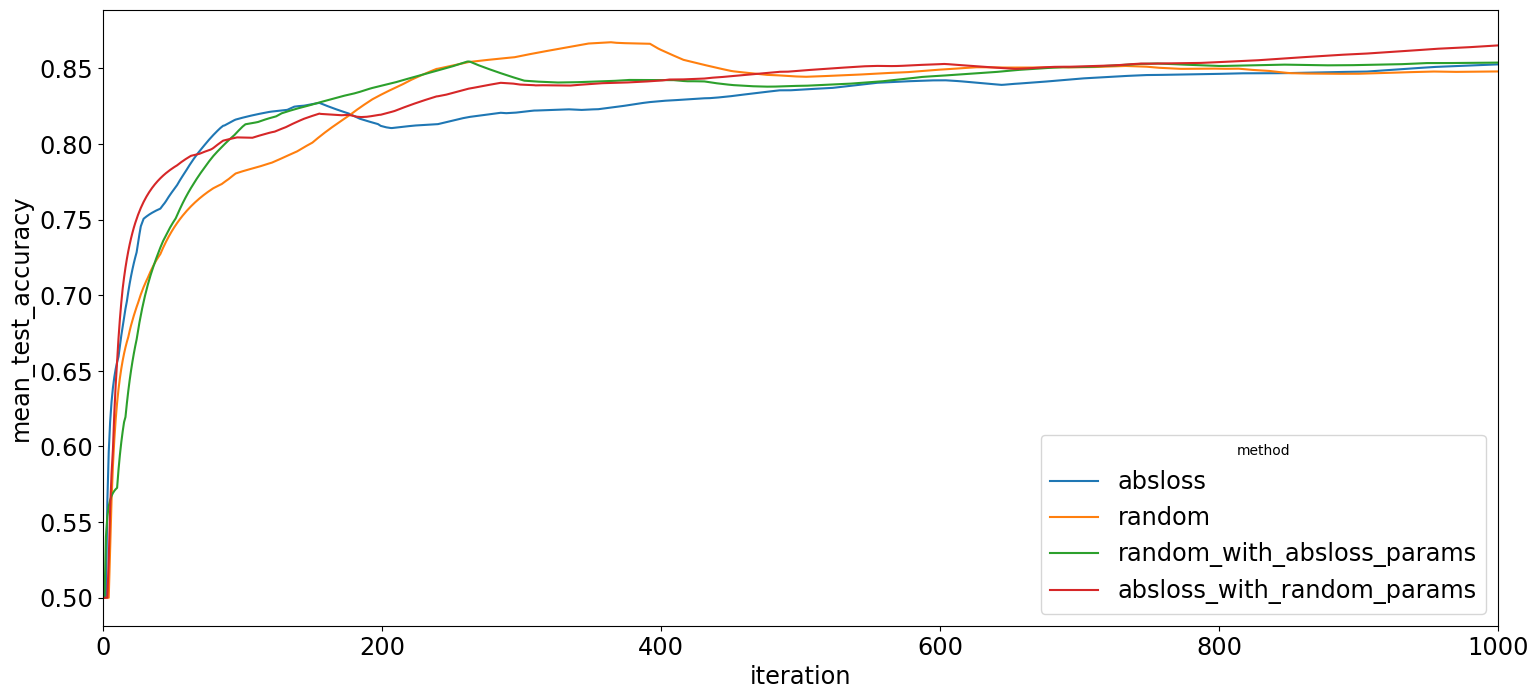

In [243]:
plt.figure(figsize=(18,8))

ax = sns.lineplot(
    data=results_df,#results_df[results_df.method.isin(["absloss", "random"])],
    x="iteration", 
    y="mean_test_accuracy",
    hue="method"
)

ax.set_xlim((0, 1000))

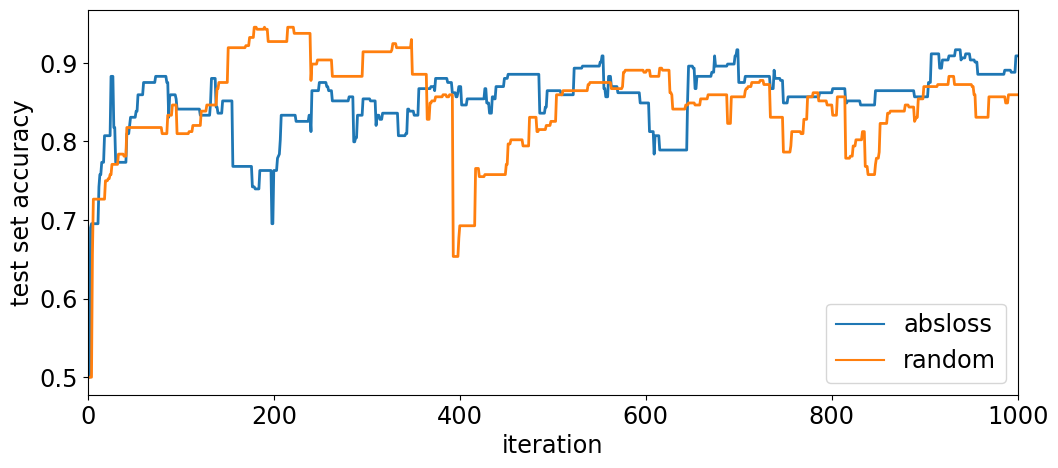

In [244]:
plt.figure(figsize=(12,5))

ax = sns.lineplot(
    data=results_df[results_df.method.isin(["absloss", "random"])],
    x="iteration", 
    y="test_accuracy",
    hue="method",
    linewidth=2
)

legend = ax.get_legend()
legend.set_title('')

ax.set(ylabel="test set accuracy")
sns.move_legend(ax, "lower right")

ax.set_xlim((0, 1000))

plt.savefig(f"figure_8a_icml_{dataset_name}.pdf", format="pdf", bbox_inches="tight")

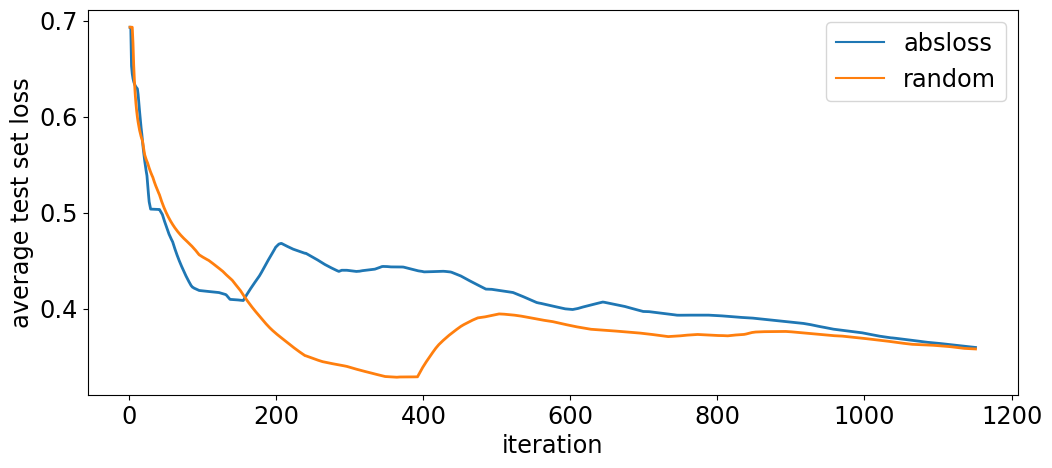

In [245]:
plt.figure(figsize=(12,5))

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'xx-large',
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
pylab.rcParams.update(params)

ax = sns.lineplot(
    data=results_df[results_df.method.isin(["absloss", "random"])],
    x="iteration", 
    y="mean_test_loss",
    hue="method",
    linewidth=2
)
ax.set(ylabel="average test set loss")
legend = ax.get_legend()
legend.set_title('')

plt.savefig(f"figure_7a_icml_{dataset_name}.pdf", format="pdf", bbox_inches="tight")

Text(0, 0.5, 'average cross entropy loss')

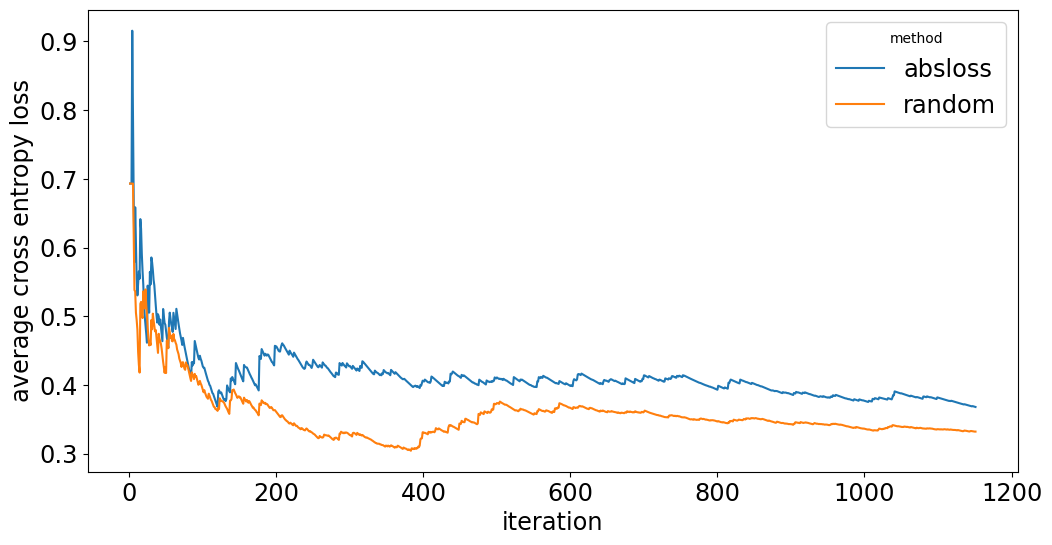

In [246]:
plt.figure(figsize=(12,6))

ax = sns.lineplot(
    data=results_df[results_df.method.isin(["absloss", "random"])],
    x="iteration", 
    y="mean_train_loss",
    hue="method"
)

ax.set_ylabel("average cross entropy loss")
#ax.set_xlim((0, 6499))

#plt.xscale('log')
#plt.yscale('log')

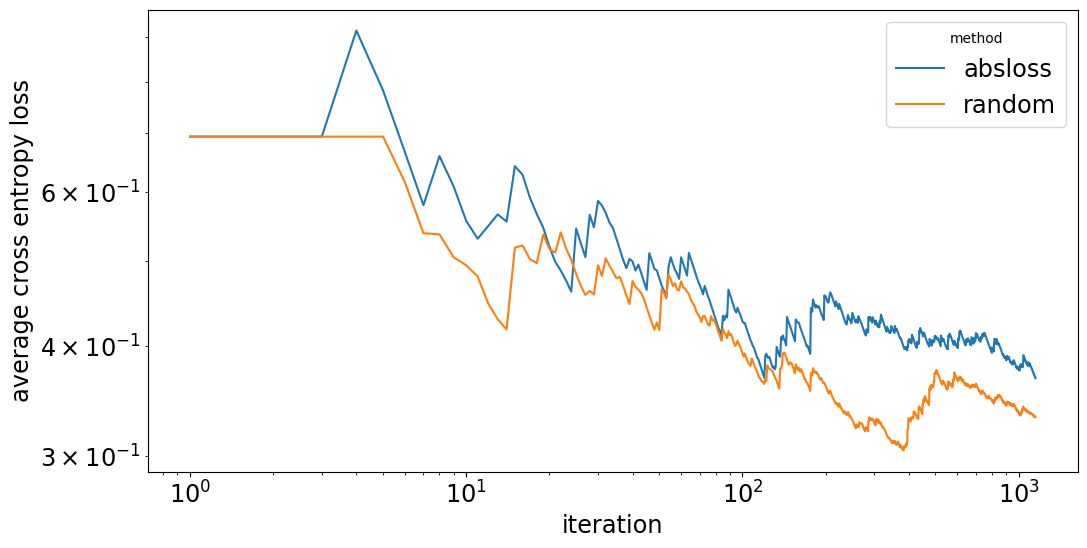

In [247]:
plt.figure(figsize=(12,6))

ax = sns.lineplot(
    data=results_df[results_df.method.isin(["absloss", "random"])],
    x="iteration", 
    y="mean_train_loss",
    hue="method"
)

ax.set_ylabel("average cross entropy loss")
#ax.set_xlim((0, 6499))

plt.xscale('log')
plt.yscale('log')

# Plot 1: train loss of rand vs Polyak exponent 
First run for various Polyak exponent values, and the run for rand for matching pz

- mean train loss curve
- mean test loss curve
- accuracy

For a single instance, polyak exponent method does:

pz = zeta ** polyakexponent

We aim to control the mean of pz across the dataset. 
we can find approximate solutions by taking zeta to be constant.

mean_pz = c ** polyakexponent

We don't know what c is because it depends on kappa, kappa0, 
and the losses in complex ways. However,  Then we can run the training loop
with polyakexp = 1 and take the empirical mean of the pz values to find our estimate for c.

Now we can find estimates of the polyakexp values that will lead to any desired mean_pz a using:

a = c ** polyakexp
log(a) = log(c ** ployakexp)
log(a) = ployakexp * log(c)
polyakexp = log(a) / log(c)

In practice, c is not a constant, but we instead have an instance-specific zeta.
As a result, it is likely that when we use this to derive this equation that gives us a value of polyakexp
for a desired sampling probability a, that the empirical mean sampling probability somewhat deviates that.

This is OK, since we're not looking to control pz precisely. Rather, we are looking to verify that polyak exponent
is more efficient than random sampling even in scenarios where we sample. We are simply looking to cover a wide range
of sampling probabilities.

To achieve a fair comparison against random sampling, we will calculate the empirical pz of the polyak exponent runs under a
and then run a random sampling under the same probability.

In [248]:
polyak_exponent_params = hyperparam_per_algo["polyak_exponent"]

polyakexp_1_results = train_model(
    X, y, Xtest, ytest, mode="polyak_exponent", **(polyak_exponent_params | {"polyakexp": 1})
)

c = np.mean(polyakexp_1_results["probs"])

Training with algorithm polyak_exponent: 1151 iterations with d=284
loss: 0.6886652594233716, train loss: 0.6931471805599453, ||theta||_1: 10.242609540652085 acc: 0.5
loss: 0.570899215363512, train loss: 1.660858206445779, ||theta||_1: 11.52747855840363 acc: 0.0
loss: 0.47021517737480895, train loss: 0.6148478633652888, ||theta||_1: 13.111889526528469 acc: 1.0
loss: 0.44376771794639164, train loss: 0.21881390972430292, ||theta||_1: 12.103893884735037 acc: 1.0
loss: 0.355004520539665, train loss: 0.6624389426777179, ||theta||_1: 12.842072833898317 acc: 1.0
loss: 0.3877318392374857, train loss: 0.9571578755719599, ||theta||_1: 16.202237008643284 acc: 0.0
loss: 0.37839145918335326, train loss: 0.02865572155696864, ||theta||_1: 13.810197459962083 acc: 1.0
loss: 0.3645377361267415, train loss: 0.49150542198183805, ||theta||_1: 12.081900620832378 acc: 1.0
loss: 0.32823684649314516, train loss: 0.11655896948359439, ||theta||_1: 11.787720245151709 acc: 1.0
loss: 0.3488947631703292, train loss:

loss: 0.28355429664408877, train loss: 0.32098885245632425, ||theta||_1: 11.841488589093396 acc: 1.0
loss: 0.3488674200027211, train loss: 0.18908469518295173, ||theta||_1: 15.642261490019903 acc: 1.0
loss: 0.3530795910925802, train loss: 0.2471970544603258, ||theta||_1: 14.876973050549179 acc: 1.0
loss: 0.35164023974739417, train loss: 0.06142003281168713, ||theta||_1: 14.098426590593272 acc: 1.0
loss: 0.3451011813035308, train loss: 0.15339435210777133, ||theta||_1: 14.036241575121693 acc: 1.0
loss: 0.34223745606453865, train loss: 0.6890901928116653, ||theta||_1: 13.121760739409577 acc: 1.0
loss: 0.35247845583398635, train loss: 0.36509704883382543, ||theta||_1: 12.991009145256335 acc: 1.0
loss: 0.3763366948180811, train loss: 0.2604984046908961, ||theta||_1: 12.713859673156247 acc: 1.0
loss: 0.37229288597603, train loss: 0.5615442995112954, ||theta||_1: 12.263818425564901 acc: 1.0
loss: 0.35497956419168414, train loss: 0.15619822571137643, ||theta||_1: 12.48135848812889 acc: 1.0
lo

In [249]:
# We're aiming to achieve sampling probabilities <0.1, 0.2, ..., 1.0>
#target_pzs = [0.1 * i for i in range(1, 11)]
target_pzs = [0.01, 0.1, 0.25, 0.5]
polyak_exps = [math.log(a) / math.log(c) for a in target_pzs]
polyak_exps

[4.699287875362884, 2.349643937681442, 1.4146266087442887, 0.7073133043721443]

In [250]:
polyak_exponent_params = hyperparam_per_algo["polyak_exponent"]

polyak_exponent_results = {
    f"polyak_exponent_{polyak_exp:.1f}": train_model(
        X, y, Xtest, ytest, mode="polyak_exponent", verbose=False, **(polyak_exponent_params | {"polyakexp": polyak_exp})
    )
    for polyak_exp in polyak_exps
}

In practice, c is not a constant, but we instead have an instance-specific zeta that depends on kappa, kappa0, and the losses in complex ways.
As a result, it is likely that the empirical mean sampling probabilities somewhat deviate from our targets target_pzs.

We now calculate the empirical pzs of these polyak exponent runs.

In [251]:
empirical_pzs = []
for key in polyak_exponent_results.keys():
    empirical_pzs += [np.mean(polyak_exponent_results[key]["probs"])]

In [252]:
empirical_pzs

[4.19033612112238e-05,
 0.2444592943447498,
 0.3386451045317793,
 0.4272766484984314]

In [253]:
rand_params = hyperparam_per_algo["random"]

rand_results = {
    f"random_{polyak_exp:.1f}": train_model(
        X, y, Xtest, ytest, mode="random", verbose=False, **(rand_params | {"pz0": empirical_pz})
    )
    for polyak_exp, empirical_pz in zip(polyak_exps, empirical_pzs)
}

In [254]:
plot1_df = results_to_df((rand_results | polyak_exponent_results))
plot1_df[['method', 'polyak_exp']] = plot1_df['method'].str.rsplit('_', n=1, expand=True)

In [255]:
plot1_df.groupby(["method", "polyak_exp", "probs"]).train_loss.mean()

method           polyak_exp  probs   
polyak_exponent  0.7         0.004629    0.582169
                             0.074253    1.007485
                             0.076853    0.359220
                             0.077709    0.275209
                             0.086928    0.223411
                                           ...   
                 4.7         0.000084    0.693147
random           0.7         0.427277    0.311991
                 1.4         0.338645    0.312363
                 2.3         0.244459    0.337000
                 4.7         0.000042    0.693147
Name: train_loss, Length: 3869, dtype: float64

In [256]:
plot1_df.groupby(["method", "polyak_exp", "probs"]).mean_train_loss.min()

method           polyak_exp  probs   
polyak_exponent  0.7         0.004629    0.302636
                             0.074253    0.304052
                             0.076853    0.404285
                             0.077709    0.300734
                             0.086928    0.308329
                                           ...   
                 4.7         0.000084    0.693147
random           0.7         0.427277    0.289818
                 1.4         0.338645    0.305578
                 2.3         0.244459    0.336632
                 4.7         0.000042    0.693147
Name: mean_train_loss, Length: 3869, dtype: float64

Polyak exp value 4.7 has rows (2302, 16)
Polyak exp value 2.3 has rows (2302, 16)
Polyak exp value 1.4 has rows (2302, 16)
Polyak exp value 0.7 has rows (2302, 16)


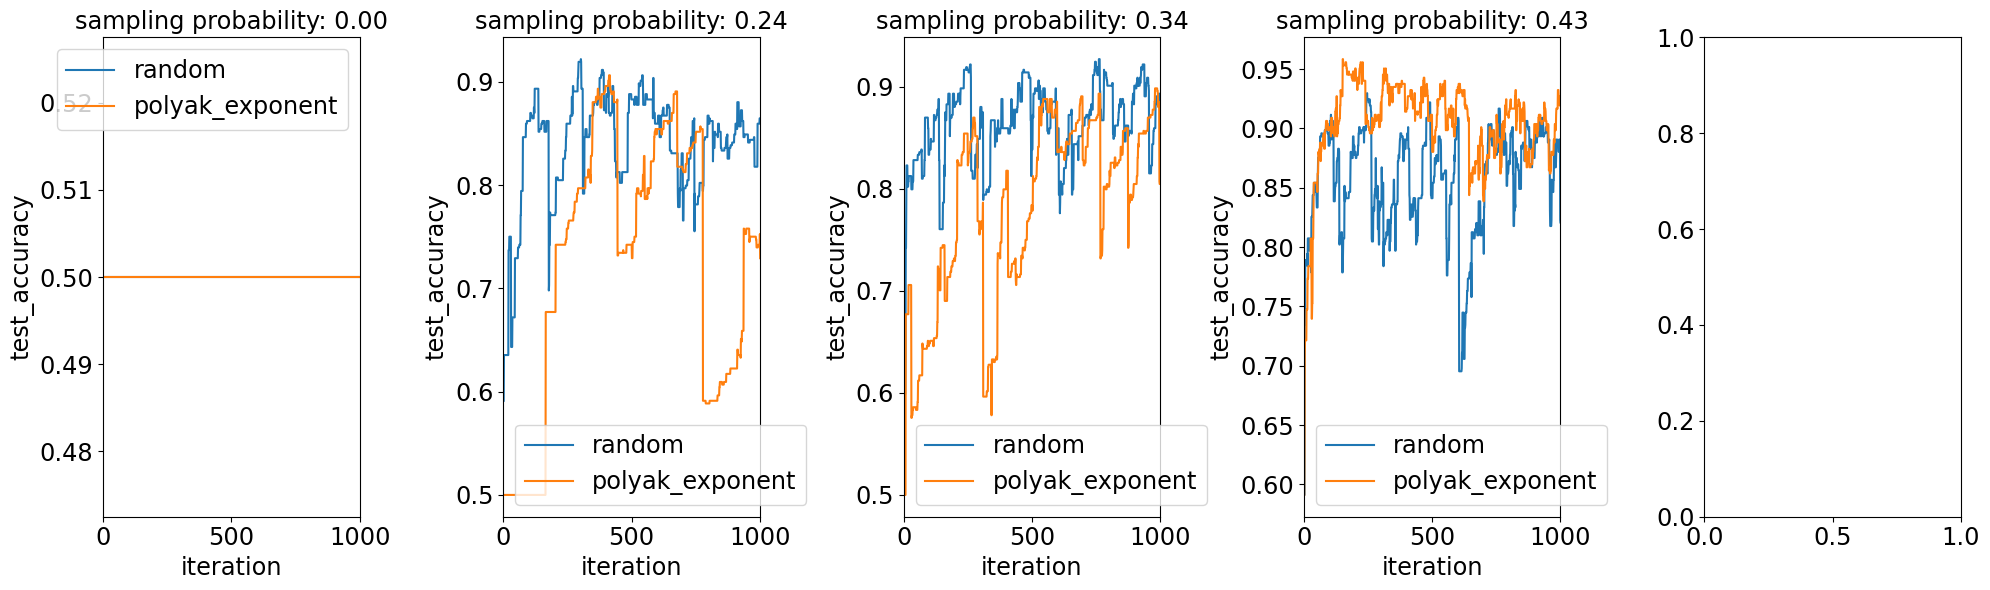

In [257]:
f, axs = plt.subplots(1, 5, figsize=(20, 6))
i = 0
for polyak_exp, pz in zip(polyak_exps, empirical_pzs):
    # Specify the current axis to plot on
    ax = axs[i]#[i // 5][i % 5]
    
    polyak_exp_key = str(round(polyak_exp, 1))
    print(f"Polyak exp value {polyak_exp_key} has rows {plot1_df[plot1_df.polyak_exp == polyak_exp_key].shape}")
    # Create the line plot on the current axis
    sns.lineplot(
        data=plot1_df[plot1_df.polyak_exp == polyak_exp_key], 
        x="iteration", 
        y="test_accuracy", 
        hue="method",
        ax=ax
    )
    
    ax.set_title(f"sampling probability: {pz:.2f}")
    ax.legend()
    ax.set_xlim((0, 1000))
    
    i+=1
f.tight_layout()

Polyak exp value 4.7 has rows (2302, 16)
Polyak exp value 2.3 has rows (2302, 16)
Polyak exp value 1.4 has rows (2302, 16)
Polyak exp value 0.7 has rows (2302, 16)


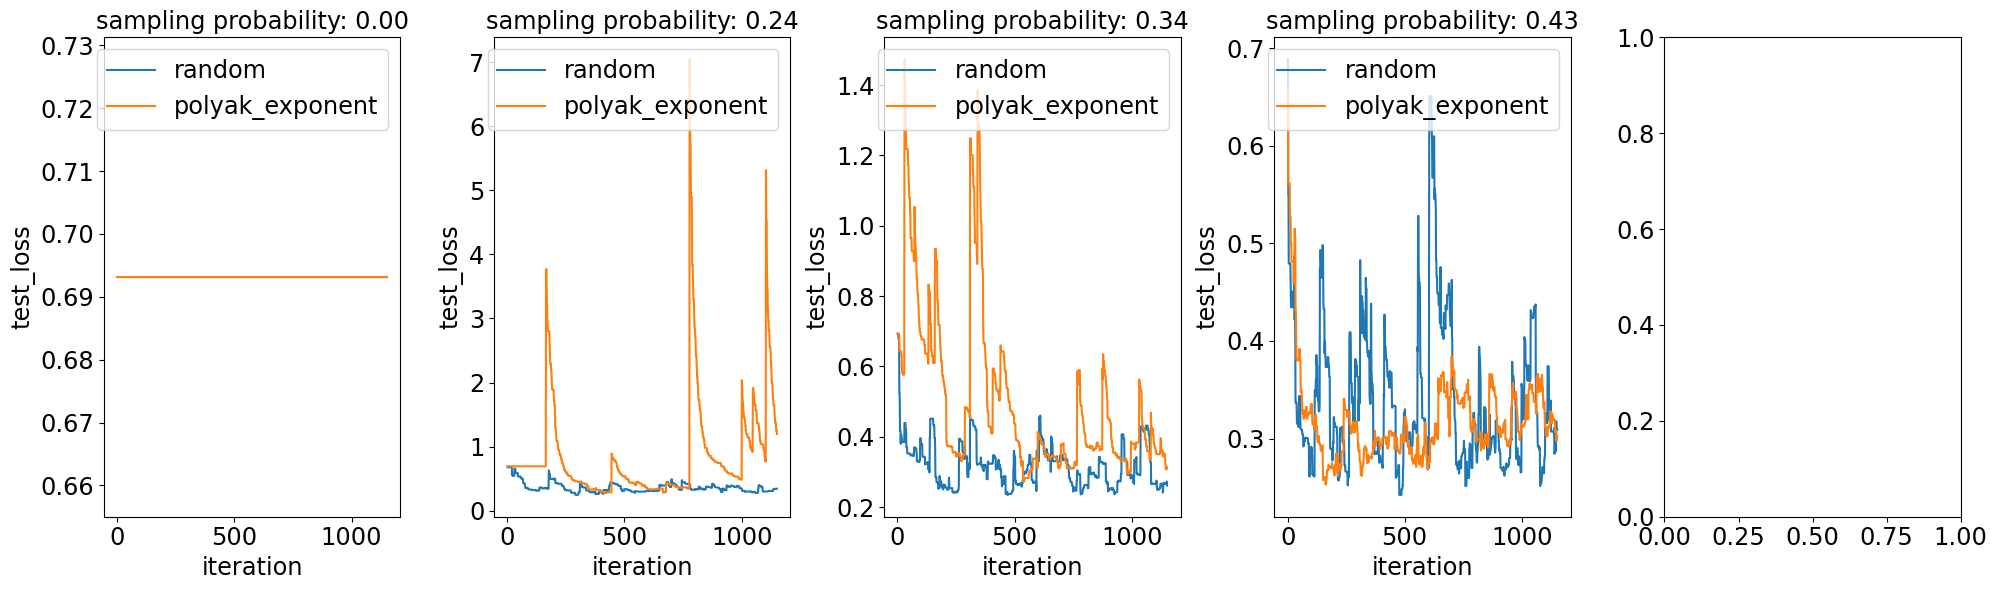

In [258]:
f, axs = plt.subplots(1, 5, figsize=(20, 6))
i = 0
for polyak_exp, pz in zip(polyak_exps, empirical_pzs):
    # Specify the current axis to plot on
    ax = axs[i]
    
    polyak_exp_key = str(round(polyak_exp, 1))
    print(f"Polyak exp value {polyak_exp_key} has rows {plot1_df[plot1_df.polyak_exp == polyak_exp_key].shape}")
    # Create the line plot on the current axis
    sns.lineplot(
        data=plot1_df[plot1_df.polyak_exp == polyak_exp_key], 
        x="iteration", 
        y="test_loss", 
        hue="method",
        ax=ax
    )
    
    ax.set_title(f"sampling probability: {pz:.2f}")
    ax.legend()
    #ax.set_xlim((0, 6000))
    #ax.set_ylim((0.63, 0.7))
    
    i+=1
f.tight_layout()

In [259]:
plot1_df["method"] = [method if method != "polyak_exponent" else "polyak_power_function" for method in plot1_df.method]

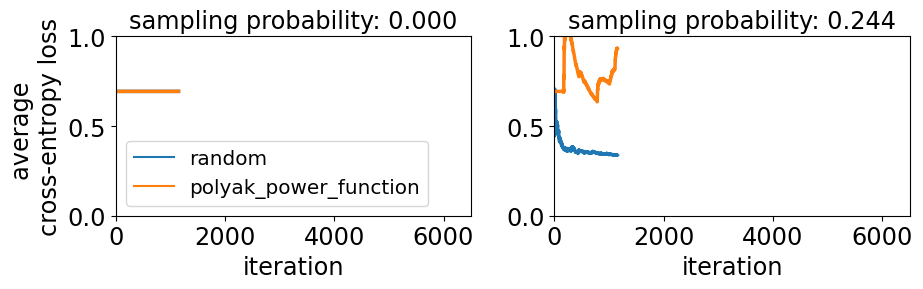

In [260]:
f, axs = plt.subplots(1, 2, figsize=(9.5, 3.0))
i = 0
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
pylab.rcParams.update(params)

for polyak_exp, pz in zip(polyak_exps[:2], empirical_pzs[:2]):
    # Specify the current axis to plot on
    ax = axs[i]
    
    polyak_exp_key = str(round(polyak_exp, 1))
    # Create the line plot on the current axis
    sns.lineplot(
        data=plot1_df[plot1_df.polyak_exp == polyak_exp_key], 
        x="iteration", 
        y="mean_train_loss", 
        hue="method",
        ax=ax,
        linewidth=2.5
    )
    
    ax.set_title(f"sampling probability: {pz:.3f}")
    ax.legend()
    ax.set_ylim((0.00, 1))
    ax.set_xlim((0, 6499))
    #ax.set_xlim((0, 6000))
    
    i+=1
    
axs[0].set_ylabel("average \ncross-entropy loss")
axs[1].set_ylabel("")

axs[1].get_legend().remove()

f.tight_layout()

plt.savefig(f"figure_2_icml_{dataset_name}.pdf", format="pdf", bbox_inches="tight")

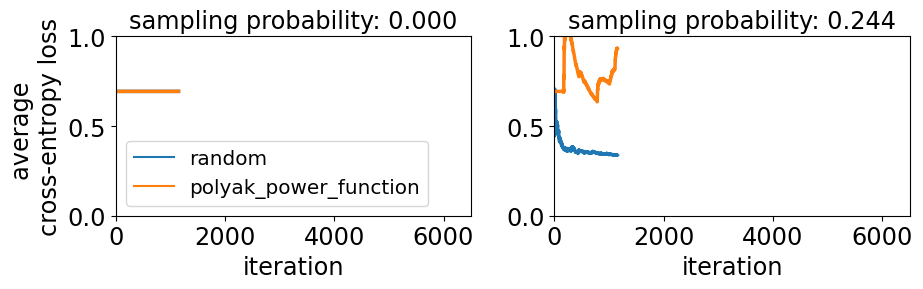

In [261]:
f, axs = plt.subplots(1, 2, figsize=(9.5, 3.0))
i = 0
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
pylab.rcParams.update(params)

for polyak_exp, pz in zip(polyak_exps[:2], empirical_pzs[:2]):
    # Specify the current axis to plot on
    ax = axs[i]
    
    polyak_exp_key = str(round(polyak_exp, 1))
    # Create the line plot on the current axis
    sns.lineplot(
        data=plot1_df[plot1_df.polyak_exp == polyak_exp_key], 
        x="iteration", 
        y="mean_train_loss", 
        hue="method",
        ax=ax,
        linewidth=2.5
    )
    
    ax.set_title(f"sampling probability: {pz:.3f}")
    ax.legend()
    ax.set_ylim((0.00, 1))
    ax.set_xlim((0, 6499))
    #ax.set_xlim((0, 6000))
    
    i+=1
    
axs[0].set_ylabel("average \ncross-entropy loss")
axs[1].set_ylabel("")

axs[1].get_legend().remove()

f.tight_layout()

plt.savefig(f"figure_2_icml_{dataset_name}.pdf", format="pdf", bbox_inches="tight")

4.19033612112238e-05
Polyak exp value 4.7 has rows (2302, 16)
0.2444592943447498
Polyak exp value 2.3 has rows (2302, 16)
0.3386451045317793
Polyak exp value 1.4 has rows (2302, 16)
0.4272766484984314
Polyak exp value 0.7 has rows (2302, 16)


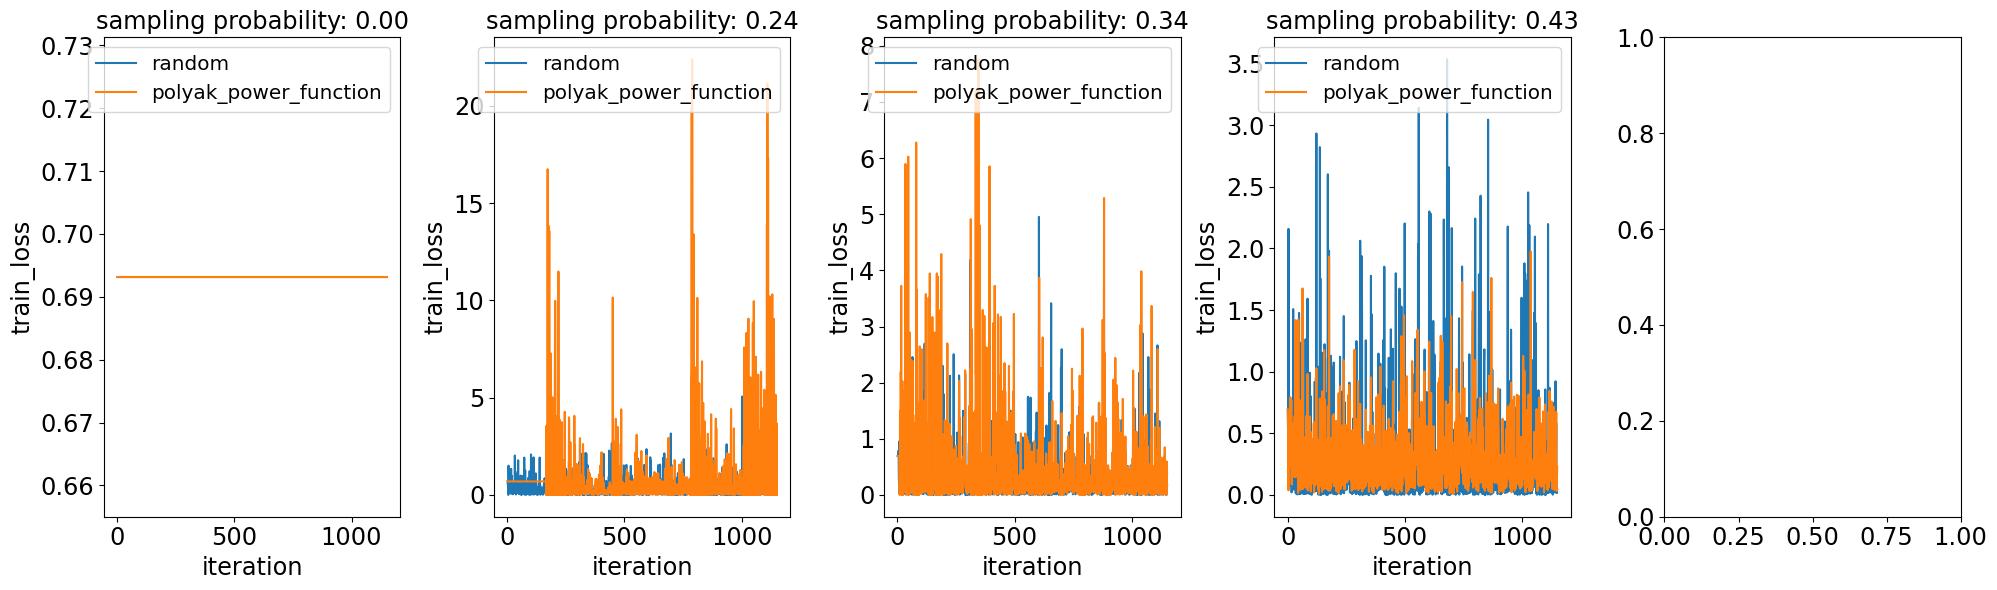

In [262]:
f, axs = plt.subplots(1, 5, figsize=(20, 6))
i = 0
for polyak_exp, pz in zip(polyak_exps, empirical_pzs):
    # Specify the current axis to plot on
    ax = axs[i]
    
    polyak_exp_key = str(round(polyak_exp, 1))
    print(pz)
    print(f"Polyak exp value {polyak_exp_key} has rows {plot1_df[plot1_df.polyak_exp == polyak_exp_key].shape}")
    # Create the line plot on the current axis
    sns.lineplot(
        data=plot1_df[plot1_df.polyak_exp == polyak_exp_key], 
        x="iteration", 
        y="train_loss", 
        hue="method",
        ax=ax
    )
    
    ax.set_title(f"sampling probability: {pz:.2f}")
    ax.legend()
    #ax.set_xlim((0, 6000))
    
    i+=1
f.tight_layout()

4.19033612112238e-05
Polyak exp value 4.7 has rows (2302, 16)
0.2444592943447498
Polyak exp value 2.3 has rows (2302, 16)
0.3386451045317793
Polyak exp value 1.4 has rows (2302, 16)
0.4272766484984314
Polyak exp value 0.7 has rows (2302, 16)


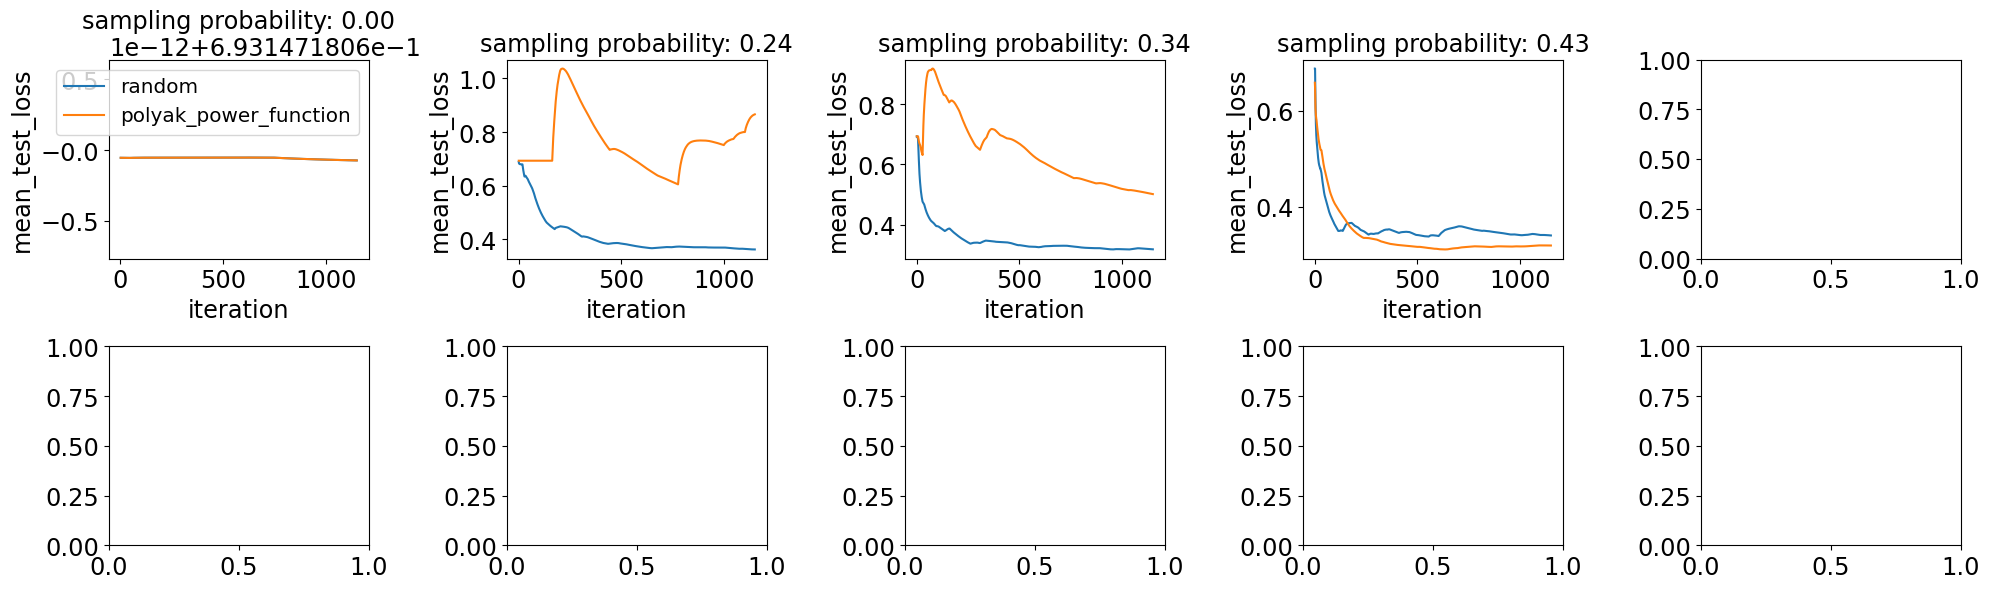

In [263]:
f, axs = plt.subplots(2, 5, figsize=(20, 6))
handles, labels = [], []

i = 0
for polyak_exp, pz in zip(polyak_exps, empirical_pzs):
    # Specify the current axis to plot on
    ax = axs[i // 5][i % 5]
    
    polyak_exp_key = str(round(polyak_exp, 1))
    print(pz)
    print(f"Polyak exp value {polyak_exp_key} has rows {plot1_df[plot1_df.polyak_exp == polyak_exp_key].shape}")
    # Create the line plot on the current axis
    sns.lineplot(
        data=plot1_df[plot1_df.polyak_exp == polyak_exp_key], 
        x="iteration", 
        y="mean_test_loss", 
        hue="method",
        ax=ax
    )
    
    ax.set_title(f"sampling probability: {pz:.2f}")
    ax.legend()
    #ax.set_xlim((0, 6000))
    if i == 0:
        h, l = ax.get_legend_handles_labels()
        handles.extend(h)
        labels.extend(l)
    else:
        ax.get_legend().remove()
    
    i+=1
f.tight_layout()

# Plot 2: Polyak absloss vs absloss
First run absloss, then we run Polyak absloss with omega=1 with yields the same sampling probability

- mean train loss curve
- mean test loss curve
- accuracy

In [264]:
hyperparam_per_algo["polyak_absloss"]

{'kappa': 10, 'kappa0': 0.9, 'eta': 0.1, 'omega': 1.0}

In [265]:
results_polyak_absloss = train_model(
    X, y, Xtest, ytest, mode="polyak_absloss", verbose=True, 
    #**(hyperparam_per_algo["polyak_absloss"] | {"omega": 1})
    **hyperparam_per_algo["polyak_absloss"]
)

Training with algorithm polyak_absloss: 1151 iterations with d=284
loss: 0.6931471805599453, train loss: 0.6931471805599453, ||theta||_1: 0.0 acc: 0.5
loss: 0.5907531877473572, train loss: 0.6839517395935605, ||theta||_1: 2.7096079367373784 acc: 1.0
loss: 0.5329505378366299, train loss: 0.5875159233975042, ||theta||_1: 5.139015720100604 acc: 1.0
loss: 0.46436406949016945, train loss: 0.6096404685284154, ||theta||_1: 7.620826353704678 acc: 1.0
loss: 0.3922603740877222, train loss: 0.12744888445376887, ||theta||_1: 8.43540162452842 acc: 1.0
loss: 0.3922603740877222, train loss: 1.0617542251942298, ||theta||_1: 8.43540162452842 acc: 0.0
loss: 0.324215159261012, train loss: 0.2634885519956857, ||theta||_1: 11.620110661112871 acc: 1.0
loss: 0.3195130379673345, train loss: 0.21230795077501177, ||theta||_1: 12.551277101121535 acc: 1.0
loss: 0.312889360627608, train loss: 0.05306567799495481, ||theta||_1: 12.159436587262721 acc: 1.0
loss: 0.3169496911599472, train loss: 0.009792941676352676, |

loss: 0.30004998125872545, train loss: 0.044669411073392236, ||theta||_1: 18.68965726555046 acc: 1.0
loss: 0.27965462458305346, train loss: 0.3419872754626876, ||theta||_1: 17.769674810467322 acc: 1.0
loss: 0.266946563428945, train loss: 0.15885481949052896, ||theta||_1: 17.110486206692116 acc: 1.0
loss: 0.26742487452191116, train loss: 0.22322393111014427, ||theta||_1: 16.70519821519703 acc: 1.0
loss: 0.2616150300402203, train loss: 0.005030121388631596, ||theta||_1: 16.794913519652557 acc: 1.0
loss: 0.2507888428132392, train loss: 0.053902497058582285, ||theta||_1: 16.210703503490315 acc: 1.0
loss: 0.2507888428132392, train loss: 0.18100421557780558, ||theta||_1: 16.210703503490315 acc: 1.0
loss: 0.2507888428132392, train loss: 0.33984230455812375, ||theta||_1: 16.210703503490315 acc: 1.0
loss: 0.25397684738396886, train loss: 1.6819980629307376, ||theta||_1: 17.95724798909209 acc: 0.0
loss: 0.26351971327823903, train loss: 0.17629782669332353, ||theta||_1: 15.972769199572546 acc: 1.

In [266]:
hppa = hyperparam_per_algo["polyak_absloss"]
hppa["omega"] *= np.mean(results_absloss["probs"]) / np.mean(results_polyak_absloss["probs"])
hyperparam_per_algo["polyak_absloss"] = hppa
print(hppa)

{'kappa': 10, 'kappa0': 0.9, 'eta': 0.1, 'omega': 0.8505320635595581}


In [267]:
plot2_df = results_to_df(
    {
        "absloss": results_absloss,
        "polyak_absloss": results_polyak_absloss,
    }
)

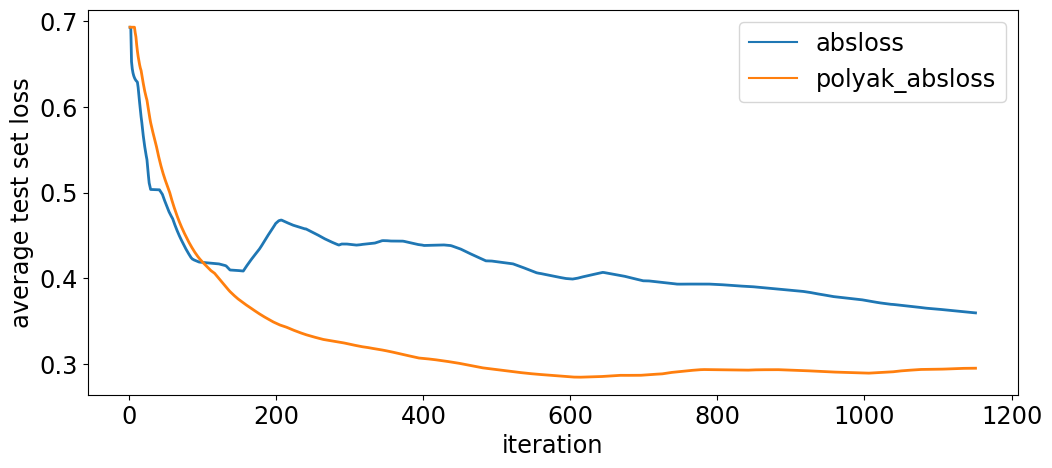

In [268]:
plt.figure(figsize=(12,5))

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'xx-large',
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
pylab.rcParams.update(params)

ax = sns.lineplot(
    data=plot2_df,
    x="iteration", 
    y="mean_test_loss",
    hue="method",
    linewidth=2
)

legend = ax.get_legend()
legend.set_title('')

ax.set(ylabel="average test set loss")

plt.savefig(f"figure_7b_icml_{dataset_name}.pdf", format="pdf", bbox_inches="tight")

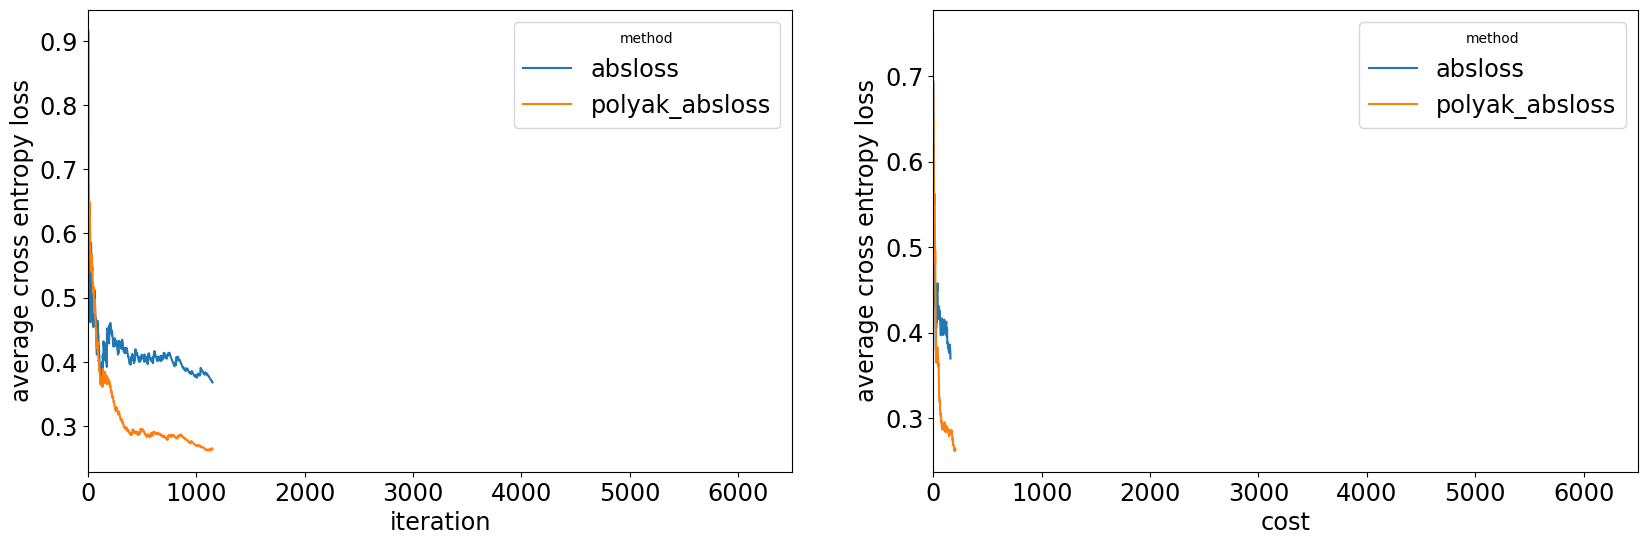

In [269]:
f, axs = plt.subplots(1, 2, figsize=(20, 6))

sns.lineplot(
    data=plot2_df,
    x="iteration", 
    y="mean_train_loss",
    hue="method",
    ax=axs[0]
)

sns.lineplot(
    data=plot2_df,
    x="cost", 
    y="mean_train_loss",
    hue="method",
    ax=axs[1]
)

for i in range(2):
    axs[i].set_ylabel("average cross entropy loss")
    axs[i].set_xlim((0, 6499))

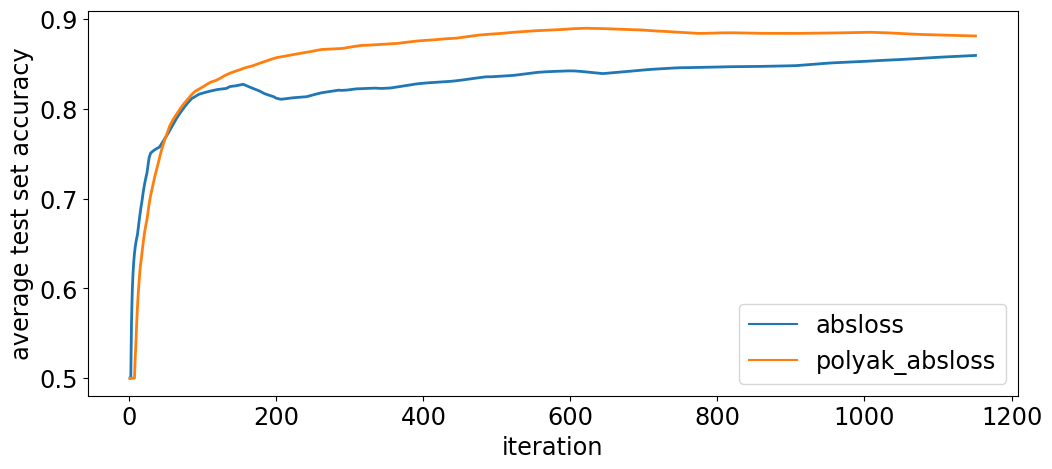

In [270]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'xx-large',
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
pylab.rcParams.update(params)

plt.figure(figsize=(12,5))

ax = sns.lineplot(
    data=plot2_df,
    x="iteration", 
    y="mean_test_accuracy",
    hue="method",
    linewidth=2
)

ax.set(ylabel="average test set accuracy")

legend = ax.get_legend()
legend.set_title('')

plt.savefig(f"figure_8b_icml_{dataset_name}.pdf", format="pdf", bbox_inches="tight")

In [271]:
plot02_df = results_to_df(
    {
        "random": results_rand,
        "absloss": results_absloss,
        "polyak_absloss": results_polyak_absloss
    }
)

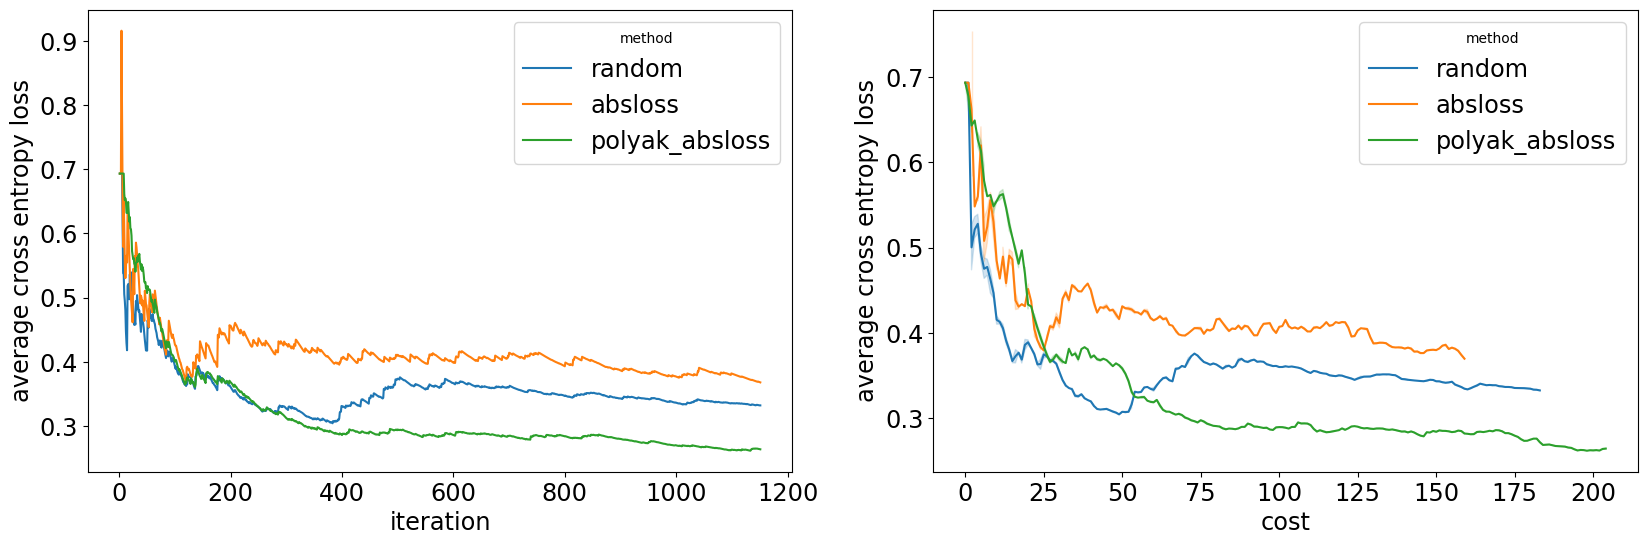

In [272]:
f, axs = plt.subplots(1, 2, figsize=(20, 6))

sns.lineplot(
    data=plot02_df,
    x="iteration", 
    y="mean_train_loss",
    hue="method",
    ax=axs[0]
)

sns.lineplot(
    data=plot02_df,
    x="cost", 
    y="mean_train_loss",
    hue="method",
    ax=axs[1]
)

for i in range(2):
    axs[i].set_ylabel("average cross entropy loss")

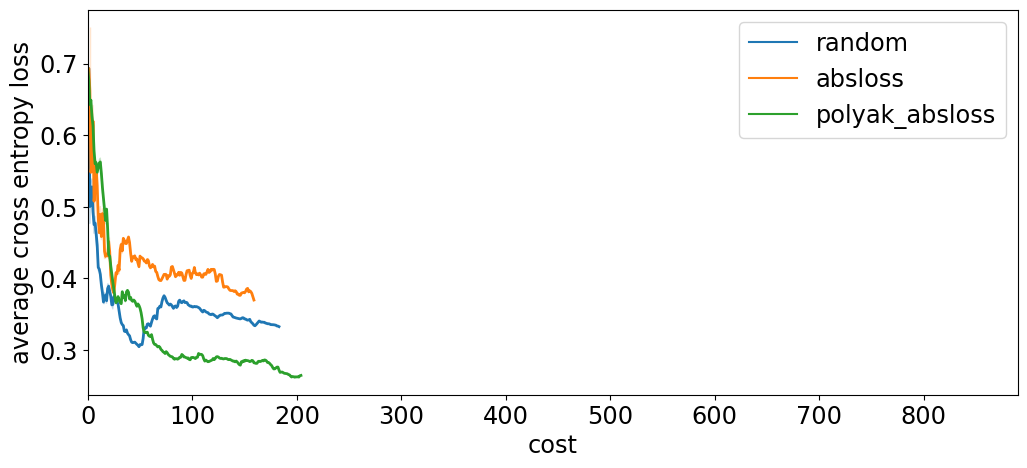

In [273]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'xx-large',
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
pylab.rcParams.update(params)

plt.figure(figsize=(12,5))

ax = sns.lineplot(
    data=plot02_df,
    x="cost", 
    y="mean_train_loss",
    hue="method",
    linewidth=2
)

ax.set(ylabel="average cross entropy loss")
ax.set_xlim((0, 890))

legend = ax.get_legend()
legend.set_title('')

plt.savefig(f"figure_6_icml_{dataset_name}.pdf", format="pdf", bbox_inches="tight")

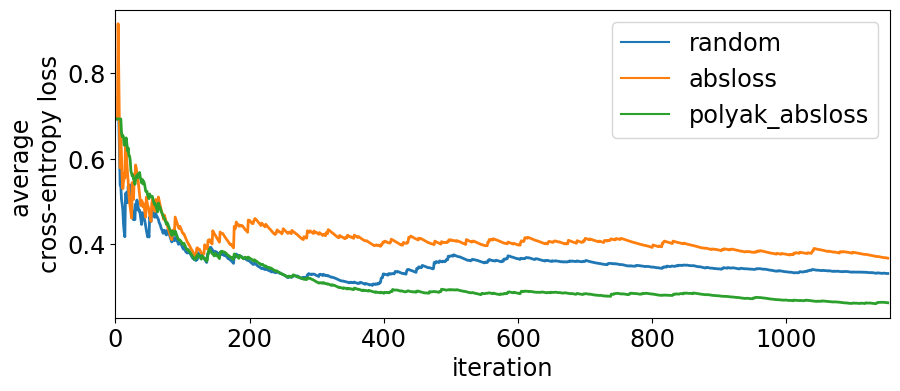

In [280]:
plt.figure(figsize=(10,4))

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'xx-large',
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
pylab.rcParams.update(params)

ax = sns.lineplot(
    data=plot02_df,
    x="iteration", 
    y="mean_train_loss",
    hue="method",
    linewidth=2
)
legend = ax.get_legend()
legend.set_title('')
ax.set_xlim((0, 1155))

ax.set(ylabel="average \ncross-entropy loss")

plt.savefig(f"figure_3_icml_{dataset_name}.pdf", format="pdf", bbox_inches="tight")
